<a href="https://colab.research.google.com/github/SumitSonar/CAPTCHA-Solver/blob/main/CaptchaRasterConverter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 94.jpg to 94.jpg
Grayscale image saved as: gray_image.jpg


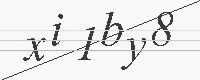

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Upload the image from local storage
from google.colab import files
uploaded = files.upload()

# Load the uploaded image
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Save the grayscale image
gray_image_path = 'gray_image.jpg'
cv2.imwrite(gray_image_path, gray_image)

print(f"Grayscale image saved as: {gray_image_path}")

# Display the grayscale image
cv2_imshow(gray_image)

Smoothed image saved as: smoothed_image.jpg


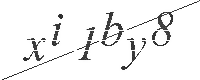

In [ ]:
import cv2

# Load the grayscale image
gray_image = cv2.imread('gray_image.jpg', cv2.IMREAD_GRAYSCALE)

# Adjust brightness

alpha = 1.5  # Brightness control (1.0 - original, >1.0 brighter, <1.0 darker)
beta = 10    # Contrast control (0 - original, >0 more contrast, <0 less contrast)
adjusted_image = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)

# Sharpen the image using unsharp masking
blurred_image = cv2.GaussianBlur(adjusted_image, (0, 0), 3)  # Apply Gaussian blur
sharpened_image = cv2.addWeighted(adjusted_image, 1.5, blurred_image, -0.5, 0)

# Fade the lines using bilateral filtering
smoothed_image_result = cv2.bilateralFilter(sharpened_image, 9, 75, 75)

# Save the smoothed image
smoothed_image_path = 'smoothed_image.jpg'  # Choose a filename
cv2.imwrite(smoothed_image_path, smoothed_image_result)

print(f"Smoothed image saved as: {smoothed_image_path}")

# Display the final result
cv2_imshow(smoothed_image_result)

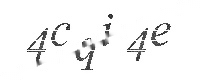

In [ ]:
import cv2
import numpy as np

def remove_diagonal_line(image_path):
    """Removes the diagonal line from the given image while preserving the alphanumeric content."""

    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Detect edges using Canny
    edges = cv2.Canny(img, 50, 150)

    # Perform Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=100, maxLineGap=10)

    # Create a mask to fill the line region
    mask = np.zeros_like(img)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(mask, (x1, y1), (x2, y2), 255, 5)

    # Inpaint the line region using a more conservative approach
    result = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)

    return result

# Example usage
image_path = "/content/smoothed_image.jpg"
result_image = remove_diagonal_line(image_path)

# Save the result
cv2.imwrite("result1.jpg", result_image)
cv2_imshow(result_image)

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def remove_diagonal_line_with_morphology(image_path):
    """Removes the diagonal line from the given image using morphological operations."""

    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Threshold the image to get a binary image
    _, binary_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    # Create a kernel for morphological operations
    kernel = np.ones((5, 5), np.uint8)

    # Perform morphological opening (erosion followed by dilation)
    opened_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

    # Perform morphological closing (dilation followed by erosion)
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Detect diagonal lines using the edge detection and Hough line transform
    edges = cv2.Canny(opened_img, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=100, maxLineGap=10)

    # Check if lines were detected
    if lines is not None:
        # Create a mask to fill the detected lines
        mask = np.zeros_like(img)
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), 255, 5)

        # Inpaint the line region
        result = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    else:
        print("No lines detected.")
        result = img  # Return the original image if no lines are found

    return result

# Example usage
image_path = "/content/smoothed_image.jpg"
result_image = remove_diagonal_line_with_morphology(image_path)

# Save the result
cv2.imwrite("result_morphology.jpg", result_image)

# Display the result
cv2_imshow(result_image)

In [ ]:
from osgeo import gdal
import numpy as np
import cv2

# Load the grayscale image using OpenCV
image = cv2.imread('/content/gray_image.jpg', cv2.IMREAD_GRAYSCALE)

# Convert to a NumPy array
image_array = np.array(image)

# Create a GeoTIFF raster file using GDAL
driver = gdal.GetDriverByName('GTiff')
rows, cols = image_array.shape
output_raster = driver.Create('output_raster1.tif', cols, rows, 1, gdal.GDT_Byte)

# Write the array to the raster band
output_raster.GetRasterBand(1).WriteArray(image_array)

# Save and close
output_raster.FlushCache()
output_raster = None

In [ ]:
from osgeo import gdal

# Open the raster image
dataset = gdal.Open('output_raster1.tif')

# Get raster band (assuming a single band image)
band = dataset.GetRasterBand(1)

# Read the band as a NumPy array
raster_array = band.ReadAsArray()

# Print pixel values
rows, cols = raster_array.shape
for i in range(rows):
    for j in range(cols):
        print(f"Pixel at ({i}, {j}): {raster_array[i, j]}")

Streaming output truncated to the last 5000 lines.
Pixel at (55, 0): 250
Pixel at (55, 1): 250
Pixel at (55, 2): 250
Pixel at (55, 3): 250
Pixel at (55, 4): 250
Pixel at (55, 5): 250
Pixel at (55, 6): 250
Pixel at (55, 7): 250
Pixel at (55, 8): 250
Pixel at (55, 9): 250
Pixel at (55, 10): 250
Pixel at (55, 11): 250
Pixel at (55, 12): 250
Pixel at (55, 13): 250
Pixel at (55, 14): 249
Pixel at (55, 15): 249
Pixel at (55, 16): 247
Pixel at (55, 17): 249
Pixel at (55, 18): 250
Pixel at (55, 19): 250
Pixel at (55, 20): 250
Pixel at (55, 21): 250
Pixel at (55, 22): 250
Pixel at (55, 23): 249
Pixel at (55, 24): 247
Pixel at (55, 25): 249
Pixel at (55, 26): 243
Pixel at (55, 27): 241
Pixel at (55, 28): 67
Pixel at (55, 29): 50
Pixel at (55, 30): 54
Pixel at (55, 31): 67
Pixel at (55, 32): 244
Pixel at (55, 33): 249
Pixel at (55, 34): 249
Pixel at (55, 35): 245
Pixel at (55, 36): 247
Pixel at (55, 37): 249
Pixel at (55, 38): 255
Pixel at (55, 39): 243
Pixel at (55, 40): 249
Pixel at (55, 41): 2

In [ ]:
import cv2
import numpy as np

# Load the grayscale image using OpenCV
image = cv2.imread('/content/output_raster1.tif')

# Get the number of pixel values directly using size attribute of NumPy array.
print(f"Number of pixel values: {image.size}")

Number of pixel values: 48000
